In [1]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

/u/ywagh/.local/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

In [3]:
slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

In [4]:
ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]   #working only with primary fields

In [33]:
#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[29]))

plot_filename = os.path.basename(filelist[29])
#******************************************************************************

In [34]:
event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 30 * u.second
exposure_time_day = exposure_time.to_value(u.day)

cadence = 30         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
min_start.format = 'jd'
max_end.format = 'jd'
k = int(np.floor((max_end - min_start)/(2*exposure_time.to(u.day))))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

event time: 2024-09-10 07:13:47.022


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/399 [00:00<?, ?it/s]

289  number of exposures could be taken tonight
problem setup completed


## Model one

In [35]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= 100)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)


number fo fields observed should be less than 289
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.03 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 784702 rows and 576277 columns.
Aggregator did 323 substitutions.
Reduced MIP has 1408 rows, 1730 columns, and 5274 nonzeros.
Reduced MIP has 1730 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.60 sec. (734.43 ticks)
Probing time = 0.00 sec. (0.36 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1408 rows, 1730 columns, and 5274 nonzeros.
Reduced MIP has 1730 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.36 ticks)
Probing time = 0.00 sec. (0.36 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.01 sec. (2.57 ticks)

       

In [36]:
selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
# print(selected_fields_ID)
selected_fields = observable_fields[selected_fields_ID]
print(selected_fields)

separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(
       separation <= (slew_speed**2 / slew_accel), 
       np.sqrt(2 * separation / slew_accel), 
       (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed
       )

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

# slew_time_max = np.max(slew_times) * u.second
# slew_time_max_ = slew_time_max.to_value(u.day) #test
# selected_fields

field_id      coord              start_time               end_time       
             deg,deg                                                     
-------- ---------------- ----------------------- -----------------------
     241 329.63168,-31.45 2024-09-10 07:13:47.022 2024-09-10 07:31:56.508
     289 324.19504,-24.25 2024-09-10 07:13:47.022 2024-09-10 08:25:53.062
     290 331.58811,-24.25 2024-09-10 07:13:47.022 2024-09-10 08:55:25.236
     291 338.98118,-24.25 2024-09-10 07:13:47.022 2024-09-10 09:24:56.510
     340 326.21746,-17.05 2024-09-10 07:13:47.022 2024-09-10 09:16:01.065
     341 333.29939,-17.05 2024-09-10 07:13:47.022 2024-09-10 09:44:17.558
     342 340.38132,-17.05 2024-09-10 07:13:47.022 2024-09-10 10:12:33.517
     343 347.46325,-17.05 2024-09-10 07:13:47.022 2024-09-10 10:40:48.930
     391  329.95489,-9.85 2024-09-10 07:13:47.022 2024-09-10 10:01:43.647
     ...              ...                     ...                     ...
     776   38.72562,54.95 2024-09-10 0

## model two

In [37]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()
num_visits = 2
num_filters = 2

x = [m2.binary_var(name=f"x_{i}") for i in range(len(selected_fields))]

s = [[m2.binary_var(name=f's_{i}_{j}') for j in range(i)] for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb =(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{k}")
       for k in range(num_visits*num_filters)] for i,row in enumerate(selected_fields)]

for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v]-tc[i][v-1] >= cadence_days * x[i], ctname = f"cadence_constraint_feild_{i}_visits_{v}")

# for v in range(num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         for j in range(i):
#             m2.add_constraint(tc[i][v] + delta * x[i] +slew_time_day[i][j] - tc[j][v] <= M * (1 - s[i][j]),
#                               ctname = f"non_overlapping1_fileds_{i}_{j}_visits_{v-1}_{v}")
#             m2.add_constraint(tc[j][v] + delta * x[j] +slew_time_day[i][j] - tc[i][v] <= M * s[i][j],
#                               ctname = f"non_overlapping2_fileds_{i}_{j}_visits_{v-1}_{v}")

for v1 in range(num_visits * num_filters):
    for v2 in range(num_visits * num_filters):  # Compare with subsequent visits
        for i in range(len(selected_fields)):
            for j in range(i):
                # Ensure no overlap between fields i and j across visits v1 and v2
                m2.add_constraint(
                    tc[i][v1] + delta * x[i] + slew_time_day[i][j] - tc[j][v2] <= M * (1 - s[i][j]),
                    ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v1}_{v2}"
                )
                m2.add_constraint(
                    tc[j][v2] + delta * x[j] + slew_time_day[i][j] - tc[i][v1] <= M * s[i][j],
                    ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v1}_{v2}"
                )
                
# for v in range(num_visits * num_filters):  # Check within the same visit
#     for i in range(len(selected_fields)):
#         for j in range(i):
#             # Ensure no overlap within the same visit
#             m2.add_constraint(
#                 tc[i][v] + delta * x[i] + slew_time_day[i][j] - tc[j][v] <= M * (1 - s[i][j]),
#                 ctname=f"non_overlapping_within_fields_{i}_{j}_visit_{v}"
#             )
#             m2.add_constraint(
#                 tc[j][v] + delta * x[j] + slew_time_day[i][j] - tc[i][v] <= M * s[i][j],
#                 ctname=f"non_overlapping_within_fields_{j}_{i}_visit_{v}"
#             )

# for v1 in range(num_visits * num_filters):  # Check across different visits
#     for v2 in range(v1 + 1, num_visits * num_filters):  # Compare subsequent visits
#         for i in range(len(selected_fields)):
#             for j in range(i):
#                 # Ensure no overlap between fields i and j across different visits
#                 m2.add_constraint(
#                     tc[i][v1] + delta * x[i] + slew_time_day[i][j] - tc[j][v2] <= M * (1 - s[i][j]),
#                     ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v1}_{v2}"
#                 )
#                 m2.add_constraint(
#                     tc[j][v1] + delta * x[j] + slew_time_day[i][j] - tc[i][v2] <= M * s[i][j],
#                     ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v1}_{v2}"
#                 )



# for v in range(1,num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         m2.add_constraint(tc[i][v] >= tc[-1][v-1] + delta * x[i], ctname = "non overlapping visits")
    
# m2.maximize(m2.sum([probabilities[i] * x[i] for i in range(len(selected_fields))]))
m2.maximize(m2.sum([x[i] for i in range(len(selected_fields))]))
m2.parameters.timelimit = 60
solution = m2.solve(log_output=True)

  0%|          | 0/100 [00:00<?, ?it/s]

worked for 100 fields
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Tried aggregator 1 time.
MIP Presolve eliminated 4224 rows and 283 columns.
MIP Presolve modified 104680 coefficients.
Reduced MIP has 154476 rows, 5167 columns, and 593437 nonzeros.
Reduced MIP has 4767 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (299.54 ticks)
Found incumbent of value 0.000000 after 0.59 sec. (560.72 ticks)
Probing time = 0.11 sec. (22.69 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 154476 rows, 5167 columns, and 593437 nonzeros.
Reduced MIP has 4767 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.35 sec. (253.67 ticks)
Probing time = 0.10 sec. (22.81 ticks)
Clique table members: 16983.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 thr

### exctracting solution

In [38]:
solution

docplex.mp.solution.SolveSolution(obj=0,values={s_1_0:1,s_4_3:1,s_5_3:1,..

In [39]:
# Get the indices of scheduled fields
scheduled_fields_ID = [i for i, v in enumerate(x) if v.solution_value == 1]
scheduled_fields = selected_fields[scheduled_fields_ID]
# scheduled_fields
scheduled_tc = [[solution.get_value(tc[i][v]) for v in range(num_visits * num_filters)] for i in scheduled_fields_ID]
scheduled_tc = np.asarray(scheduled_tc)

for i in range(num_visits*num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:,i]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### garbage

## plotting

/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}'

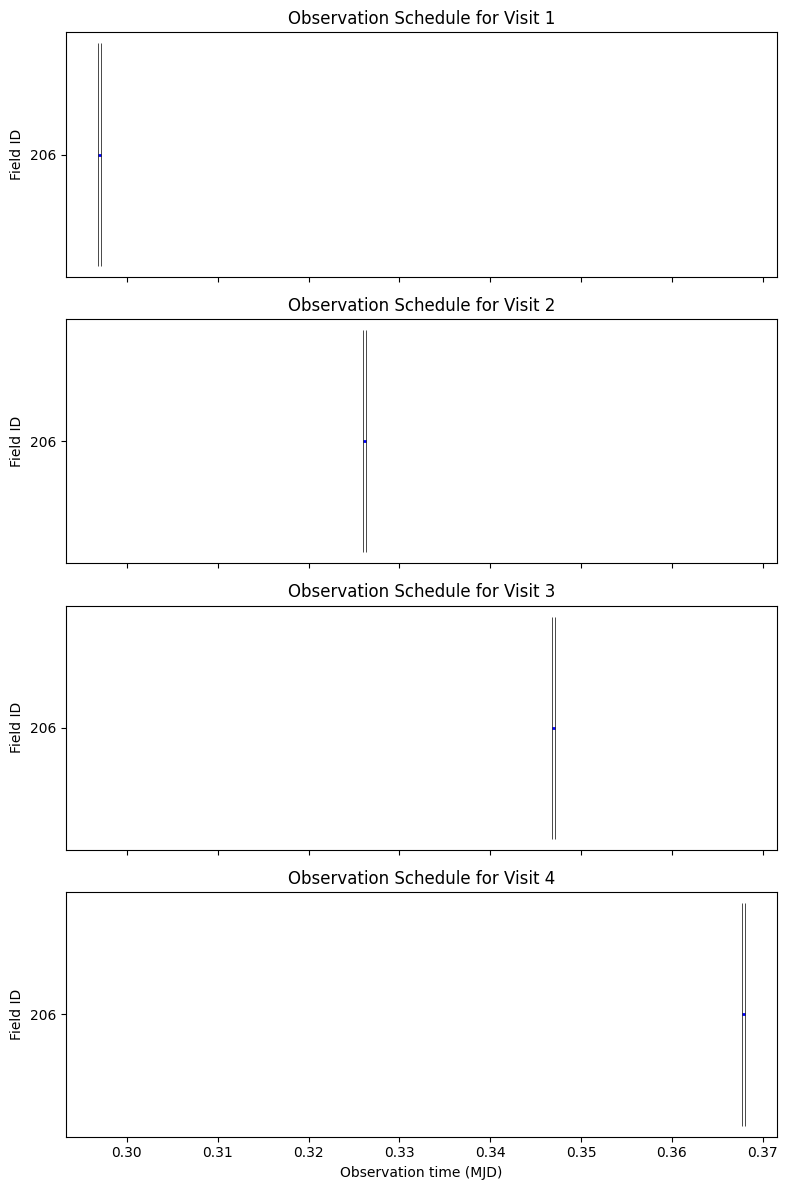

In [ ]:
n_visits = num_visits*num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    scheduled_fields[start_col] = Time(scheduled_fields[start_col], format='mjd')
    scheduled_fields[start_col].format = 'iso'
    scheduled_fields[end_col] = scheduled_fields[start_col] + exposure_time_day
    
    scheduled_fields.sort(end_col)
    
    ax = axes[i]  
    ax.hlines(
        np.arange(len(scheduled_fields)),
        scheduled_fields[start_col].mjd,
        scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    for j in range(len(scheduled_fields)):
        ax.vlines(
            scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    ax.set_yticks(np.arange(len(scheduled_fields)))
    ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
plt.show()
